# AnyoneAI - Sprint Project 02
> Home Credit Default Risk

You've been learning a lot about Machine Learning Algorithms, now we you're gonna be asked to put it all togheter. 

You will create a complete pipeline to preprocess the data, train your model and then predict values for the [Home Credit Default Risk](https://www.kaggle.com/competitions/home-credit-default-risk/) Kaggle competition.


## 1. Introduction

This is a binary Classification task: we want to predict whether the person applying for a home credit will be able to repay their debt or not. Our model will have to predict a 1 indicating the client will have payment difficulties: he/she will have late payment of more than X days on at least one of the first Y installments of the loan in our sample, 0 in all other cases.

The dataset is composed of multiple files with different information about loans taken. In this project, we will work exclusively with the primary files: `application_train_aai.csv` and `application_test_aai.csv`.

We will use [Area Under the ROC Curve](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc?hl=es_419) as the evaluation metric, so our models will have to return the probabilities that a loan is not paid for each row.

In [1]:
# Import libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils.validation import check_is_fitted
from scipy.stats import randint

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb

from src import config, data_utils, preprocessing

### Getting the data

To access the data for this project, you only need to execute the code below. This will download three files inside the `dataset` folder:

- `application_train_aai.csv`: Training dataset you must use to train and find the best hyperparameters on your model.

- `application_test_aai.csv`: Test dataset without labels. Because of the absence of labels, you can't use this dataset for your experiments. You will use the file only at the end after you choose what you think is the best model for the tasks. You will have to use that model to fill values in the `TARGET` column using the model predictions. Then submit this dataset alongside this Jupyter notebook, AnyoneAI will internally evaluate your model's accuracy in the hidden data and communicate later ;).

- `HomeCredit_columns_description.csv`: This file contains descriptions for the columns in train and test datasets.


1.1. Load the training and test datasets. Also, the auxiliary file `HomeCredit_columns_description.csv` has additional information about the features in the dataset.

**Don't change anything in this cell, just make it run correctly**

In [2]:
app_train, app_test, columns_description = data_utils.get_datasets()

if app_train.shape == (246008, 122):
    print("Success: app_train shape is correct!")
else:
    raise ValueError("Train dataset shape is incorrect, please review your code")

if isinstance(app_train, pd.DataFrame):
    print("Success: app_train type is correct!")
else:
    raise ValueError("Train dataset type is incorrect, please review your code")

if app_test.shape == (61503, 122):
    print("Success: app_test shape is correct!")
else:
    raise ValueError("Test dataset shape is incorrect, please review your code")

if isinstance(app_test, pd.DataFrame):
    print("Success: app_test type is correct!")
else:
    raise ValueError("Test dataset type is incorrect, please review your code")

Success: app_train shape is correct!
Success: app_train type is correct!
Success: app_test shape is correct!
Success: app_test type is correct!


### Exploratory Data Analysis

A lot of the analysis of the data can be found on publicly available Kaggle kernels or blog posts, but you need to make sure you understand the dataset's properties before starting working on it, so we'll do exploratory data analysis for the main files.

#### Dataset Basics

1.2. Print how many samples do we have in our train and test datasets.

In [3]:
### TODO Complete in this cell: shape of the dataset
print("Train shape: "+ str(app_train.shape))
print("Test shape: "+ str(app_test.shape))

Train shape: (246008, 122)
Test shape: (61503, 122)


1.3. List all columns in the train dataset.

In [4]:
### TODO Complete in this cell: Show all columns in the training dataset
print(app_train.columns)

Index(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY',
       ...
       'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20',
       'FLAG_DOCUMENT_21', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_YEAR'],
      dtype='object', length=122)


1.4. Show the first 5 records of the training dataset, transpose the dataframe to see each record as a column and features as rows, make sure all features are visualized. Take your time to review what kind of information you can gather from this data.

For reference only, it should look like this:

|0|1|2|3|4
|---|---|---|---|---
Unnamed: 0|187399|84777|268140|270686|33785
SK_ID_CURR|317244|198357|410700|413785|139141
TARGET|0|0|0|0|0
NAME_CONTRACT_TYPE|Cash loans|Cash loans|Cash loans|Cash loans|Cash loans
...|...|...|...|...|...
AMT_REQ_CREDIT_BUREAU_DAY|0.0|0.0|0.0|0.0|0.0

In [5]:
### TODO Complete in this cell: show first 5 records in a transposed table
app_train.head(5).transpose()

,0,1,2,3,4
SK_ID_CURR,428247,140966,407283,434300,446788
TARGET,0,0,0,0,0
NAME_CONTRACT_TYPE,Cash loans,Cash loans,Revolving loans,Cash loans,Cash loans
CODE_GENDER,F,M,F,F,F
FLAG_OWN_CAR,N,Y,N,N,N
...,...,...,...,...,...
AMT_REQ_CREDIT_BUREAU_DAY,NaN,0.0,0.0,0.0,0.0
AMT_REQ_CREDIT_BUREAU_WEEK,NaN,0.0,0.0,0.0,0.0
AMT_REQ_CREDIT_BUREAU_MON,NaN,0.0,0.0,0.0,0.0
AMT_REQ_CREDIT_BUREAU_QRT,NaN,0.0,0.0,1.0,0.0


1.5. Show the distribution of the target variable values: print the total value count and the percentage of each value, plot this relationship.

Total value count: 246008
Percentage of 0 class: 92.0
Percentage of 1 class: 8.0


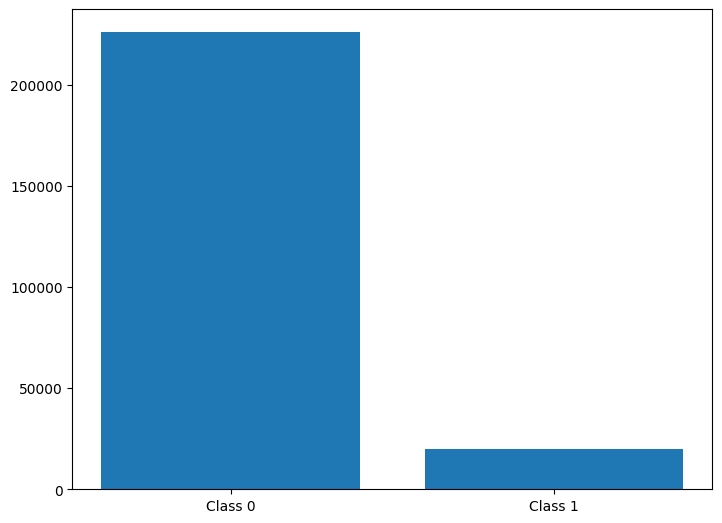

In [6]:
### TODO Complete in this cell: show distribution of target variable
totalCount = app_train["TARGET"].count()
totalTarget = app_train["TARGET"].value_counts()
print(f"Total value count: {totalCount}")
print(f"Percentage of 0 class: {totalTarget[0]*100/totalCount:.1f}")
print(f"Percentage of 1 class: {totalTarget[1]*100/totalCount:.1f}")
y = [totalTarget[0], totalTarget[1]]
x = ["Class 0", "Class 1"] 
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(x,y)
plt.show()

1.6. Show the number of columns of each data type.

Just for giving you an idea, the output should look like this (not exactly the same numbers):

```python
float64    45
int64      32
object     10
```

In [7]:
### TODO Complete in this cell: show number of columns per data type
print(app_train.dtypes.value_counts())

float64    65
int64      41
object     16
dtype: int64


1.7. For categorical variables (`object` data type), show the number of distinct values in each column (number of labels).

Just for giving you an idea, the output should look like this (not exactly the same numbers):

```python
NAME_CONTRACT_TYPE             5
CODE_GENDER                    2
FLAG_OWN_CAR                   1
FLAG_OWN_REALTY                1
...
```

In [8]:
### TODO Complete in this cell: show number of unique values per categorical column
cols = app_train.select_dtypes(include=["object"]).columns

for col in cols:
    print(col, app_train[col].unique().size)


NAME_CONTRACT_TYPE 2
CODE_GENDER 3
FLAG_OWN_CAR 2
FLAG_OWN_REALTY 2
NAME_TYPE_SUITE 8
NAME_INCOME_TYPE 8
NAME_EDUCATION_TYPE 5
NAME_FAMILY_STATUS 6
NAME_HOUSING_TYPE 6
OCCUPATION_TYPE 19
WEEKDAY_APPR_PROCESS_START 7
ORGANIZATION_TYPE 58
FONDKAPREMONT_MODE 5
HOUSETYPE_MODE 4
WALLSMATERIAL_MODE 8
EMERGENCYSTATE_MODE 3


1.8. Analyzing missing data: show the percentage of missing data for each column ordered by percentage descending (show only the 20 columns with higher missing pct)

Just for giving you an idea, the output should look like this (not exactly the same numbers and columns names):

```python
                   Total   Percent
COMMONAREA_AVG    121000      85.2
COMMONAREA_MODE   121000      76.6
COMMONAREA_MEDI   121000      62.9
...
```

In [9]:
### TODO Complete in this cell: checking missing data
nulls = app_train.isnull().sum()
totalRows = len(app_train)
perc_by_col = round(nulls*100/totalRows, 1)

#Creating Dataframe with results
dfResult = pd.concat([nulls,perc_by_col],axis=1)
dfResult.columns = ["TOTAL","PERCENT"]
dfResult.sort_values("PERCENT", ascending= False).head(20)

,TOTAL,PERCENT
COMMONAREA_MEDI,172189,70.0
COMMONAREA_AVG,172189,70.0
COMMONAREA_MODE,172189,70.0
NONLIVINGAPARTMENTS_MODE,171096,69.5
NONLIVINGAPARTMENTS_AVG,171096,69.5
NONLIVINGAPARTMENTS_MEDI,171096,69.5
LIVINGAPARTMENTS_MODE,168494,68.5
LIVINGAPARTMENTS_AVG,168494,68.5
FONDKAPREMONT_MODE,168561,68.5
LIVINGAPARTMENTS_MEDI,168494,68.5


#### Analyzing distribution of variables

1.9. Show the distribution of credit amounts.

*Hint:* Take a look at `AMT_CREDIT` column.

450000.0     7751
675000.0     7060
225000.0     6497
180000.0     5890
270000.0     5874
             ... 
1547464.5       1
2334303.0       1
967761.0        1
984591.0        1
1499256.0       1
Name: AMT_CREDIT, Length: 5248, dtype: int64


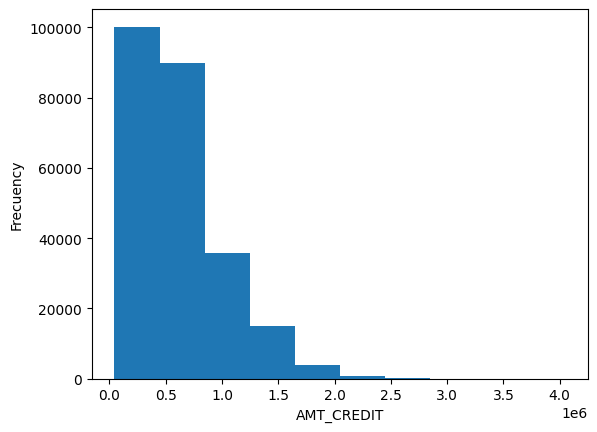

In [10]:
### TODO Complete in this cell: distribution of credit amounts
amt_credit_distribution = app_train["AMT_CREDIT"].value_counts()
print(amt_credit_distribution)
plt.hist(app_train["AMT_CREDIT"])
plt.xlabel("AMT_CREDIT")
plt.ylabel("Frecuency")
plt.show()

1.10. Plot the education level of the credit applicants, show the percentages of each category. Also print the total counts for each category.

*Hint:* Take a look at `NAME_EDUCATION_TYPE` column.

C:\Users\Alejo\AppData\Local\Temp\ipykernel_8008\881163153.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(education_level_counts.index, rotation = 90)


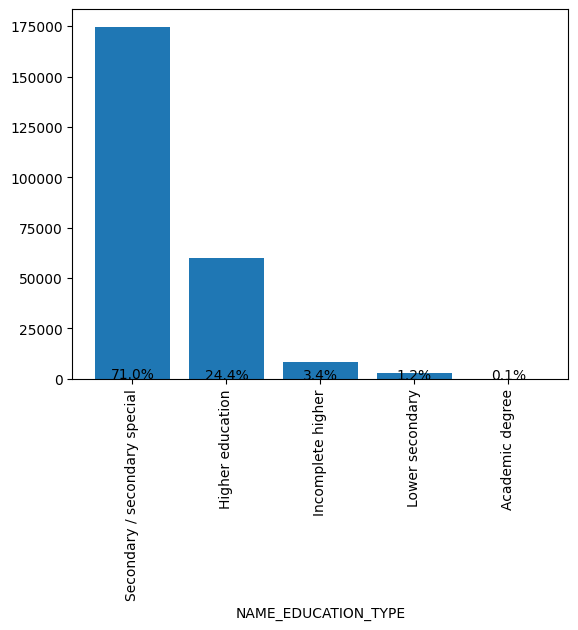

In [11]:
### TODO Complete in this cell: level of education plot
education_level_perc = round(app_train["NAME_EDUCATION_TYPE"].value_counts(normalize=True)*100,1)
education_level_counts = app_train["NAME_EDUCATION_TYPE"].value_counts(normalize=False)
fig, ax = plt.subplots()
ax.bar(education_level_counts.index, education_level_counts.values)
ax.set_xlabel("NAME_EDUCATION_TYPE")

for i,v in enumerate(education_level_perc.values):
    print()
    ax.text(i, v+1 , str(v)+"%", ha = "center")

ax.set_xticklabels(education_level_counts.index, rotation = 90)
plt.show()

1.11. Plot the distribution of ocupation of the loan applicants.

*Hint:* Take a look at `OCCUPATION_TYPE` column.

C:\Users\Alejo\AppData\Local\Temp\ipykernel_8008\2457170988.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(occupation_type_distribution.index, rotation = 90)


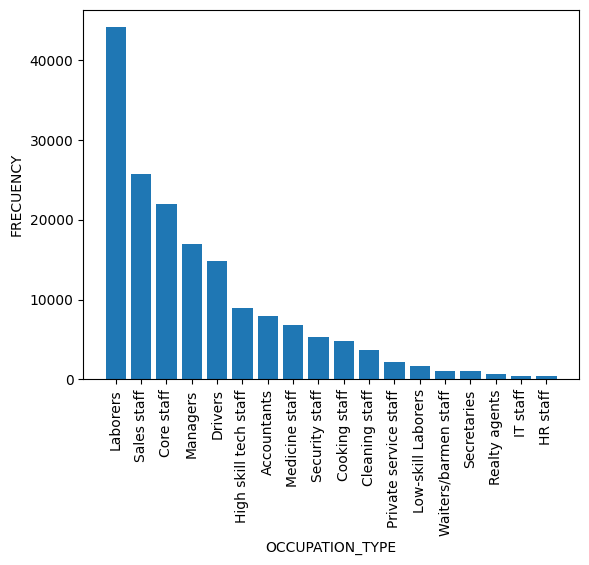

In [12]:
### TODO Complete in this cell: ocupation of applicants
occupation_type_distribution = app_train["OCCUPATION_TYPE"].value_counts()

fig, ax = plt.subplots()
ax.bar(occupation_type_distribution.index, occupation_type_distribution.values)
ax.set_xlabel("OCCUPATION_TYPE")
ax.set_ylabel("FRECUENCY")
ax.set_xticklabels(occupation_type_distribution.index, rotation = 90)

plt.show()

1.12. Plot the family status of the applicants.

*Hint:* Take a look at `NAME_FAMILY_STATUS` column.

C:\Users\Alejo\AppData\Local\Temp\ipykernel_8008\4100304037.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(name_family_status_distribution.index, rotation = 90)


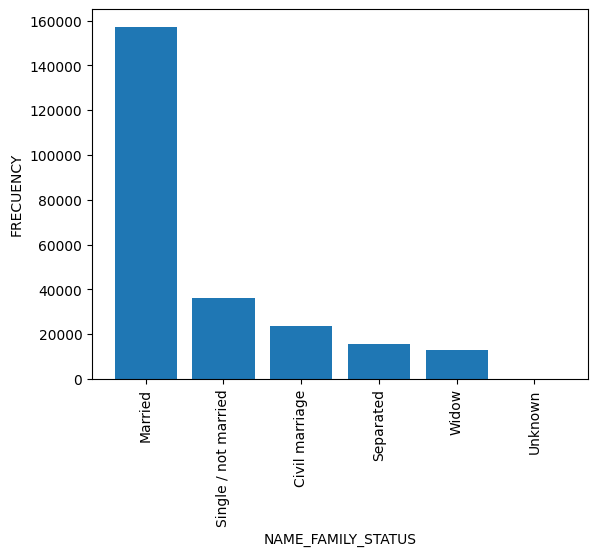

In [13]:
### TODO Complete in this cell: family status
name_family_status_distribution = app_train["NAME_FAMILY_STATUS"].value_counts()
name_family_status_distribution

fig, ax = plt.subplots()
ax.bar(name_family_status_distribution.index, name_family_status_distribution.values)
ax.set_xlabel("NAME_FAMILY_STATUS")
ax.set_ylabel("FRECUENCY")
ax.set_xticklabels(name_family_status_distribution.index, rotation = 90)

plt.show()

1.13. Plot the income type of applicants grouped by the target variable.

*Hint:* Take a look at `NAME_INCOME_TYPE` and `TARGET` columns. You can use `hue` parameter on Seaborn to group samples using another categorical feature.

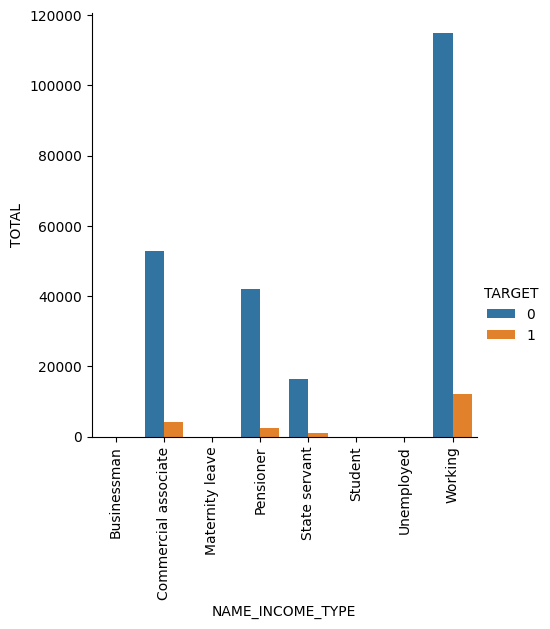

,NAME_INCOME_TYPE,TARGET,TOTAL
0,Businessman,0,8
1,Commercial associate,0,52917
2,Commercial associate,1,4273
3,Maternity leave,0,3
4,Maternity leave,1,1
5,Pensioner,0,41902
6,Pensioner,1,2339
7,State servant,0,16411
8,State servant,1,988
9,Student,0,11


In [14]:
### TODO Complete in this cell: Income type of applicants by target variable
name_income_type_grouped_df = app_train[["NAME_INCOME_TYPE","TARGET"]]
name_income_type_grouped_df = name_income_type_grouped_df.assign(TOTAL = 1)
name_income_type_grouped_df = name_income_type_grouped_df.groupby(["NAME_INCOME_TYPE","TARGET"]).count().reset_index()

sns.catplot(x = "NAME_INCOME_TYPE", y = "TOTAL", hue = "TARGET", kind = "bar" , data = name_income_type_grouped_df)
plt.xticks(rotation = 90)
plt.show()
name_income_type_grouped_df

## 2. Preprocessing

2.1. The next step will be to separate our train and test datasets columns between Features (the input to the model) and Targets (what the model has to predict with the given features).

- Assign to `X_train` all the columns from `app_train` that should be used as features for training our models.
- Assign to `y_train` the single column from `app_train` that should be used as our target (i.e. what we want to predict).
- Assign to `X_test` all the columns from `app_test` that should be used as features for training our models.
- Assign to `y_test` the single column from `app_test` that should be used as our target (i.e. what we want to predict).

To do that, you will have to complete the function `data_utils.get_feature_target()` in all the parts with a `TODO` mark.


**Don't change anything in this cell, just make it run correctly**

In [3]:
# Now we execute the function above to get the result
X_train, y_train, X_test, y_test = data_utils.get_feature_target(app_train, app_test)

if X_train.shape == (246008, 121):
    print("Success: X_train shape is correct!")
else:
    raise ValueError("X_train dataset shape is incorrect, please review your code")

if isinstance(X_train, pd.DataFrame):
    print("Success: X_train type is correct!")
else:
    raise ValueError("Train dataset type is incorrect, please review your code")

if y_train.shape == (246008,) or y_train.shape == (246008, 1):
    print("Success: y_train shape is correct!")
else:
    raise ValueError("Train labels shape is incorrect, please review your code")

if X_test.shape == (61503, 121):
    print("Success: X_test shape is correct!")
else:
    raise ValueError("Test dataset shape is incorrect, please review your code")

if isinstance(X_test, pd.DataFrame):
    print("Success: X_test type is correct!")
else:
    raise ValueError("Test dataset type is incorrect, please review your code")

if y_test.shape == (61503,) or y_test.shape == (61503, 1):
    print("Success: y_test shape is correct!")
else:
    raise ValueError("Test labels shape is incorrect, please review your code")

Success: X_train shape is correct!
Success: X_train type is correct!
Success: y_train shape is correct!
Success: X_test shape is correct!
Success: X_test type is correct!
Success: y_test shape is correct!


2.2. In order to avoid overfitting while searching for the best model hyperparameters, it's always a good idea to split our training dataset into two new sets called `train` and `validation`. 

While the `train` data will be used to fit the model and adjust its internal weights, the `validation` will be exclusively used to test the model performance on unseen data during training, it's like a testing dataset used during experimentation.

Remember we can't use the `test` dataset to validate the model performance because this one lacks of labels :( So the `validation` data will be the only resource you will have to evaluate the final model performance before doing your submission.

To do that, you will have to complete the function `data_utils.get_train_val_sets()` in all the parts with a `TODO` mark.

This function should perform these activities:
- Use the `sklearn.model_selection.train_test_split` function with `X_train`, `y_train` datasets.
- Assign only 20% of the dataset for testing (see `test_size` parameter in `train_test_split`)
- Assign a seed so we get reproducible output across multiple function calls (see `random_state` parameter in `train_test_split`)
- Shuffle the data (see `shuffle` parameter in `train_test_split`)

For reference, see:
- [Scikit-learn train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)
- [Wikipedia: Training, validation, and test data sets](https://en.wikipedia.org/wiki/Training,_validation,_and_test_data_sets)
- [Train Test Validation Split: How To & Best Practices](https://www.v7labs.com/blog/train-validation-test-set)


**Don't change anything in this cell, just make it run correctly**

In [4]:
# Now we execute the function above to get the result
X_train, X_val, y_train, y_val = data_utils.get_train_val_sets(X_train, y_train)

if X_train.shape == (196806, 121):
    print("Success: X_train shape is correct!")
else:
    raise ValueError("X_train dataset shape is incorrect, please review your code")

if isinstance(X_train, pd.DataFrame):
    print("Success: X_train type is correct!")
else:
    raise ValueError("Train dataset type is incorrect, please review your code")

if y_train.shape == (196806,) or y_train.shape == (196806, 1):
    print("Success: y_train shape is correct!")
else:
    raise ValueError("Train labels shape is incorrect, please review your code")

if X_val.shape == (49202, 121):
    print("Success: X_test shape is correct!")
else:
    raise ValueError("Test dataset shape is incorrect, please review your code")

if isinstance(X_val, pd.DataFrame):
    print("Success: X_test type is correct!")
else:
    raise ValueError("Test dataset type is incorrect, please review your code")

if y_val.shape == (49202,) or y_val.shape == (49202, 1):
    print("Success: y_test shape is correct!")
else:
    raise ValueError("Test labels shape is incorrect, please review your code")

Success: X_train shape is correct!
Success: X_train type is correct!
Success: y_train shape is correct!
Success: X_test shape is correct!
Success: X_test type is correct!
Success: y_test shape is correct!


2.3. In this section, you will code a function to make all the data pre-processing for the dataset. What you have to deliver is a function that takes `X_train`, `X_val`, and `X_test` dataframes, processes all features, and returns the transformed data as numpy arrays ready to be used for training.

The function should perform these activities, in this order:

1. Correct outliers/anomalous values in numerical columns (`DAYS_EMPLOYED` column)
2. Encode string categorical features (dytpe `object`):
    - If the feature has 2 categories encode using binary encoding
    - More than 2 categories, use one hot encoding 
3. Impute values for all columns with missing data (use median as imputing value)
4. Feature scaling with Min-Max scaler.

Complete the function `preprocessing.preprocess_data()` following the instructions given above.

In the following cell, we are going to execute the preprocessing function you've just coded. No need to modify this.

**Important Note:** From now on, you must always use `train_data` for training your models and `val_data` only for the final evaluation of the model trained. About `test_data`, it will be used at the end only for submitting your final model predictions and be evaluated on our side with the hidden annotations.


**Don't change anything in this cell, just make it run correctly**

In [17]:
train_data, val_data, test_data = preprocessing.preprocess_data(X_train, X_val, X_test)


if train_data.shape == (196806, 246):
    print("Success: train_data shape is correct!")
else:
    raise ValueError("train_data dataset shape is incorrect, please review your code")

if isinstance(train_data, np.ndarray):
    print("Success: train_data type is correct!")
else:
    raise ValueError("Train dataset type is incorrect, please review your code")

if val_data.shape == (49202, 246):
    print("Success: val_data shape is correct!")
else:
    raise ValueError("val_data dataset shape is incorrect, please review your code")

if isinstance(val_data, np.ndarray):
    print("Success: val_data type is correct!")
else:
    raise ValueError("Validation dataset type is incorrect, please review your code")

if test_data.shape == (61503, 246):
    print("Success: test_data shape is correct!")
else:
    raise ValueError("test_data dataset shape is incorrect, please review your code")

if isinstance(test_data, np.ndarray):
    print("Success: test_data type is correct!")
else:
    raise ValueError("Test dataset type is incorrect, please review your code")

Input train data shape:  (196806, 121)
Input val data shape:  (49202, 121)
Input test data shape:  (61503, 121) 

Success: train_data shape is correct!
Success: train_data type is correct!
Success: val_data shape is correct!
Success: val_data type is correct!
Success: test_data shape is correct!
Success: test_data type is correct!


## 3. Training Models

As usual, you will start training simple models and will progressively move to more complex models and pipelines.

**Pro tip:** It is of utmost importance to make an accurate estimation of the time required to train a machine learning model. Because of this, we recommend you to use Python [time](https://docs.python.org/3/library/time.html) library or Jupyter magic function `%%time` on the cell you're training your model to get an estimate of the time it took to fit your data.

### Baseline: LogisticRegression

3.1. Import LogisticRegression from sklearn and train a model using the preprocesed train data from the previous section, and just default parameters. If you receive a warning because the algorithm failed to converge, try increasing the number of iterations or decreasing the C parameter.

Assign the trained model to `log_reg` variable.

**Don't change anything in this cell, just make it run correctly**

In [18]:
%%time
# This is an example code on how to:
#   - Create and fit (train) a logistic regression
#   - Assign to `log_reg` variable
log_reg = None
log_reg = LogisticRegression(C=0.0001)
log_reg.fit(train_data, y_train)

CPU times: total: 15.5 s
Wall time: 4.22 s


LogisticRegression(C=0.0001)

**Don't change anything in this cell, just make it run correctly**

In [19]:
if isinstance(log_reg, LogisticRegression):
    print("Success: Logistic regression model type is correct!")
else:
    raise ValueError(
        "Logistic regression model type is incorrect, please review your code"
    )

check_is_fitted(log_reg)

Success: Logistic regression model type is correct!


3.2. Use the trained model to predict probabilities for `train_data` and `val_data`.

**Important note:** When using the function `predict_proba()` for getting model probabilities you will get, for each sample, a tuple indicating the probability for class 0 and for class 1 respectively. For computing the AUC ROC score we only need the probability that the debt is not repaid (equivalent to class 1). As an example, the result from running `predict_proba()` on validation dataset will have a shape of `(49202, 2)` but, we only need the second column from that matrix, which corresponds to the class 1.


**Don't change anything in this cell, just make it run correctly**

In [20]:
# Example code to show you how to use the Logistic Regression model
# to predict probabilities for each class and then, use the probabilities for the
# class 1 only.

# Train data predictions (class 1)
log_reg_train = log_reg.predict_proba(train_data)[:, 1]

# Validation data predictions (class 1)
log_reg_val = log_reg.predict_proba(val_data)[:, 1]

3.3. Get AUC ROC score on train and validation datasets. See [scikit-learn AUC ROC function](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html) for a working implementation.

Assign the AUC ROC score to `lr_roc_auc` variable.


**Don't change anything in this cell, just make it run correctly**

In [21]:
# Example code to show you how to get the ROC AUC Score on train and val datasets

# Train ROC AUC Score
roc_auc_train = roc_auc_score(y_true=y_train, y_score=log_reg_train)
print(f"Train ROC AUC Score: {roc_auc_train:.4f}")

# Validation ROC AUC Score
roc_auc_val = roc_auc_score(y_true=y_val, y_score=log_reg_val)
print(f"Validation ROC AUC Score: {roc_auc_val:.4f}")

Train ROC AUC Score: 0.6802
Validation ROC AUC Score: 0.6777


At this point, the model should produce a result of around 0.67.

**Question:** Comparing train and validation results, do you observe underfitting, overfitting, or none of those two?

According to results, neither underfitting nor underfitting is observed, but ROC AUC Scored is not very good.

**Don't change anything in this cell, just make it run correctly**

In [22]:
if isinstance(roc_auc_val, float):
    print("Success: AUC ROC score type is correct!")
else:
    raise ValueError("AUC ROC score type is incorrect, please review your code")

if roc_auc_val >= 0.6:
    print("Success: AUC ROC score is correct!")
else:
    raise ValueError("AUC ROC score is incorrect, please review your code")

Success: AUC ROC score type is correct!
Success: AUC ROC score is correct!


### Training a Random Forest Classifier 

You're gonna start working in more complex models: ensambles, particularly, you're going to use the Random Forest Classifier from Scikit Learn. 

3.4. Train a RandomForestClassifier, print the time taken by the fit function. Just use default hyperparameters, except for `n_jobs`, which should be set to "-1" to allow the library to use all CPU cores to speed up training time.

In [23]:
%%time
# TODO Write your code here for training a Random Forest model.
#   - Please use sklearn.ensemble.RandomForestClassifier() class.
#   - Assign the model to the variable `rf`.
#   - Remember to fit the model only on `train_data`.
rf = RandomForestClassifier(n_jobs=-1)
rf.fit(train_data, y_train)

CPU times: total: 11min 25s
Wall time: 2min 17s


RandomForestClassifier(n_jobs=-1)

**Don't change anything in this cell, just make it run correctly**

In [24]:
if isinstance(rf, RandomForestClassifier):
    print("Success: RandomForestClassifier model type is correct!")
else:
    raise ValueError(
        "RandomForestClassifier model type is incorrect, please review your code"
    )

check_is_fitted(rf)

Success: RandomForestClassifier model type is correct!


3.5. Use the classifier to predict probabilities for `train_data` and `val_data`.

In [25]:
# TODO Use the Random Forest model to predict probabilities for each class and then,
# use the probabilities for the class 1 only.

# Train data predictions (class 1)
rf_pred_train = rf.predict_proba(train_data)[:,1]

# Validation data predictions (class 1)
rf_pred_val = rf.predict_proba(val_data)[:,1]

3.6. Get AUC ROC score on train and validation datasets.


In [26]:
# TODO Get the ROC AUC Score on train_data and val_data datasets.
# Train ROC AUC Score
roc_auc_train = roc_auc_score(y_true=y_train, y_score=rf_pred_train)
print(f"Train ROC AUC Score: {roc_auc_train:.4f}")
# Validation ROC AUC Score
roc_auc_val = roc_auc_score(y_true=y_val, y_score=rf_pred_val)
print(f"Train ROC AUC Score: {roc_auc_train:.4f}")

Train ROC AUC Score: 1.0000
Train ROC AUC Score: 1.0000


At this point, the model should produce a result around 0.7.

**Question:** Comparing train and validation results, do you observe underfitting, overfitting, or none of those two?

The model is overfitted, even though it has a ROC AUC value of 1, this is because the majority class (0), has a much higher percentage of data than the minority class (1)

### Randomized Search with Cross Validation

So far, we've only created models using the default hyperparameters of each algorithm. This is usually something that we would only do for baseline models, hyperparameter tuning is a very important part of the modeling process and is often the difference between having an acceptable model or not.

But, there are usually lots of hyperparameters to tune and a finite amount of time to do it, you have to consider the time and resources it takes to find an optimal combination of them. In the previous section you trained a random forest classifier and saw how much it took to train it once in your PC. If you want to do hyperparameter optimization you now have to consider that you will have to train the algorithm N number of times, with N being the cartesian product of all parameters. 

Furthermore, you can't validate the performance of your trained models on the test set, as this data should only be used to validate the final model. So we have to implement a validation strategy, K-Fold Cross Validation being the most common. But this also adds time complexity to our training, because we will have to train each combinations of hyperparameters M number of times, X being the number of folds in which we divided our dataset, so the total number of training iterations will be NxM... this resulting number can grow VERY quickly.

Fortunately there are strategies to mitigate this, here you're going to select a small number of hyperparameters to test a RandomForestClassifier, and use a Randomized Search algorithm with K-Fold Cross Validation to avoid doing a full search across the grid. 

Remember: take in consideration how much time it took to train a single classifier, and define the number of cross validations folds and iterations of the search accordingly. 
A recommendation: run the training process, go make yourself a cup of coffee, sit somewhere comfortably and forget about it for a while.


3.7. Use `sklearn.model_selection.RandomizedSearchCV()` to find the best combination of hyperparameters for a Random Forest model. 

The validation metric used to evaluate the models should be "roc_auc" (i.e. `scoring="roc_auc"`).

In [27]:
%%time

# TODO Write your code here for training a Random Forest model using Random Search
# of hyper-parameters.
#   - Please use sklearn.model_selection.RandomizedSearchCV() and
#     sklearn.ensemble.RandomForestClassifier() classes.
#   - Assign the RandomizedSearchCV model to the variable `rf_random`.
#   - Remember to fit the model only on `train_data`.

params_dict = {
    'n_estimators': randint (1, 100),
    'max_depth' : randint (1, 50),
    'max_features': ['sqrt', 'log2', None],
    'criterion': ['gini','entropy']
}
rf2 = RandomForestClassifier(n_jobs = -1)
rf_random =  RandomizedSearchCV(rf2, param_distributions=params_dict,n_iter=20, 
    random_state= 42, scoring='roc_auc', n_jobs=-1, verbose = 1)
rf_random.fit(train_data, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
CPU times: total: 57min 54s
Wall time: 7h 11min 7s


RandomizedSearchCV(estimator=RandomForestClassifier(n_jobs=-1), n_iter=20,
                   n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000022A3F088490>,
                                        'max_features': ['sqrt', 'log2', None],
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000022A3F036390>},
                   random_state=42, scoring='roc_auc', verbose=1)

3.8. Use the classifier to predict probabilities on the train and test data.


In [28]:
# TODO Use the RandomizedSearchCV model to predict probabilities for each class and
# then, use the probabilities for the class 1 only.

# Train data predictions (class 1)
rf_tuned_pred_train = rf_random.predict_proba(train_data)[:, 1]

# Validation data predictions (class 1)
rf_tuned_pred_val = rf_random.predict_proba(val_data)[:, 1]

3.9. Get AUC ROC score on train and validation datasets.

In [29]:
# TODO Get the ROC AUC Score on train_data and val_data datasets.
# Train ROC AUC Score
roc_auc_train = roc_auc_score(y_true = y_train, y_score = rf_tuned_pred_train)
print(f"Train ROC AUC Score: {roc_auc_train:.4f}")

# Validation ROC AUC Score
roc_auc_val = roc_auc_score(y_true = y_val, y_score = rf_tuned_pred_val)
print(f"Validation ROC AUC Score: {roc_auc_val:.4f}")

Train ROC AUC Score: 0.8160
Validation ROC AUC Score: 0.7352


In [30]:
# The best hyperparameters tunning for random forest with RandomSearch are:
rf_random.best_estimator_

RandomForestClassifier(max_depth=11, max_features=None, n_estimators=88,
                       n_jobs=-1)

At this point, the model should produce a result around 0.7 or higher.

**Question:** Comparing train and validation results, do you observe underfitting, overfitting, or none of those two?

In this case, there is no overfitting neither underfitting, and a better generalization of the model is observed with respect to the training with a tree with default parameters. It is also seen that in training a lower error was obtained than in validation.

## 4. Predict unlabeled data

Now it's time to finally use the `test_data` samples. Because we don't have the labels we can't see how the model performs on this dataset (╯°□°)╯︵ ┻━┻

But... don't worry, we will internally evaluate your model and give feedback on the results!

In the cells below:
- Take your best model
- Take `test_data` (i.e. the dataset after doing the preprocessing and feature engineering part)
- Run the data through your model and save the predictions on the `TARGET` column in the `app_test` DataFrame (yeah that we've loaded at the very beginning of this notebook).
    - `TARGET` column values must be the probabilities for class 1. So remember to use the `predict_proba()` function from your model as we did in the previous sections.
- Save the modified version of the DataFrame with the same name it has before (`dataset/application_test_aai.csv`) and don't forget to submit it alongside the rest of this sprint project code
- And finally, don't get confused, you shouldn't submit `dataset/application_train_aai.csv`. So please don't upload your solution with this heavy dataset inside.

Let's say your best model is called `best_credit_model_ever`, then your code should be exactly this:

```python
    test_preds = best_credit_model_ever.predict_proba(test_data)[:, 1]
    app_test["TARGET"] = test_preds
    app_test.to_csv(config.DATASET_TEST, index=False)
```


In [31]:
%%time

# TODO Use your best model and call the predict_proba() on test_data then,
# use the probabilities for the class 1 only.
# Then, put the predictions in app_test["TARGET"] and save the DataFrame as a csv
# with the same name it originally has ("application_test_aai.csv").}

# The best model obtained was 
test_preds = rf_random.predict_proba(test_data)[:, 1]
app_test["TARGET"] = test_preds
app_test.to_csv(config.DATASET_TEST, index=False)


CPU times: total: 17.7 s
Wall time: 14.1 s


## 5. Optional exercises

### Optional: Training a LightGBM model 

5.1. Gradient Boosting Machine is one of the most used machine learning algorithms for tabular data. Lots of competitions have been won using models from libraries like XGBoost or LightGBM. You can try using [LightGBM](https://lightgbm.readthedocs.io/en/latest/) to train a new model an see how it performs compared to the other classifiers you trained. 

In [19]:
### Complete in this cell: train a LightGBM model
train_data_lgbm = lgb.Dataset(train_data, label=y_train)
param_dict = {
    'objective':'binary',
    'metric': 'binary_logloss',
    'boosting': 'gbdt',
    'num_leaves' : 20,
    'learning_rate': 0.04,
    'feature_fraction':0.7
}

gbm_model = lgb.train(params=param_dict, train_set = train_data_lgbm, num_boost_round=100) 

[LightGBM] [Info] Number of positive: 15714, number of negative: 181092
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.036783 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11639
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.079845 -> initscore=-2.444453
[LightGBM] [Info] Start training from score -2.444453


In [20]:
# Predictions for train and val
y_pred_gbm_train = gbm_model.predict(train_data)
y_pred_gbm_val = gbm_model.predict(val_data)

In [21]:
# Train ROC AUC Score
roc_auc_train_gbm = roc_auc_score(y_true=y_train, y_score=y_pred_gbm_train)
print(f"Train ROC AUC Score: {roc_auc_train_gbm:.4f}")

# Validation ROC AUC Score
roc_auc_val = roc_auc_score(y_true=y_val, y_score=y_pred_gbm_val)
print(f"Validation ROC AUC Score: {roc_auc_val:.4f}")


Train ROC AUC Score: 0.7628
Validation ROC AUC Score: 0.7497


### Optional: Using Scikit Learn Pipelines 

5.2. So far you've created special functions or blocks or code to chain operations on data and then train the models. But, reproducibility is important, and you don't want to have to remember the correct steps to follow each time you have new data to train your models. There are a lots of tools out there that can help you with that, here you can use a [Sklearn Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) to process your data.

In [81]:
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

class CustomEncoder (BaseEstimator, TransformerMixin):
    # Constructor
    def __init__(self):
        super().__init__()
        
    # Function that makes fit
    def fit (self, X, y=None):
        working_train_df = X.copy()

        self.cols_numeric = [col for col in working_train_df.columns if working_train_df[col].dtype != 'object']
        self.cols_object = [col for col in working_train_df.columns if working_train_df[col].dtype == 'object']
        self.cols_ordinal = [col for col in self.cols_object if working_train_df[col].nunique() == 2]
        self.cols_oneHot = [col for col in self.cols_object if working_train_df[col].nunique() > 2]

        self.encoder_ordinal = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=np.nan)
        self.encoder_oneHot = OneHotEncoder(handle_unknown="ignore", sparse_output=False)

        self.encoder_ordinal.fit(working_train_df[self.cols_ordinal])
        self.encoder_oneHot.fit(working_train_df[self.cols_oneHot])
        self.columns_oneHot_encoded = self.encoder_oneHot.get_feature_names_out(self.cols_oneHot)

        return self
    
    #Function that makes transform.
    def transform (self, X):
        working_train_df = X.copy()
        working_train_df = working_train_df.reset_index().drop("index",axis=1)
        working_train_df["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace=True)

        working_train_df_cols_ord = self.encoder_ordinal.transform(working_train_df[self.cols_ordinal])
        working_train_df_cols_oneH = self.encoder_oneHot.transform(working_train_df[self.cols_oneHot])
        
        working_train_df_encoded = pd.concat([
                    working_train_df[self.cols_numeric],
                    pd.DataFrame(working_train_df_cols_ord, columns = self.cols_ordinal ), 
                    pd.DataFrame(working_train_df_cols_oneH, columns = self.columns_oneHot_encoded)]
                    , axis = 1)

        return working_train_df_encoded


In [88]:
# Creating steps for pipeline
# 1. Custom Encoding
# 2. Imputer by using mean
# 3. Scaling by using MinMaxScaler by default

preprocessing_steps = [
    ('custom_pre', CustomEncoder()),
    ('imputer', SimpleImputer(strategy = "mean")),
    ('scale', MinMaxScaler())
]

# Create pipeline
preprocesing_pipeline = Pipeline(steps=preprocessing_steps)
# Fit pipeline using train data
preprocesing_pipeline.fit(X_train)

Pipeline(steps=[('custom_pre', CustomEncoder()), ('imputer', SimpleImputer()),
                ('scale', MinMaxScaler())])

In [93]:
# It is possible to use the desired ML algorthim into pipeline, for instance for random forest will be
pipeline_randomForest = Pipeline([
    ('preprocessing', preprocesing_pipeline),
    ('rf', RandomForestClassifier(n_jobs=-1))
])

# Fit the model
pipeline_randomForest.fit(X_train, y_train)

#For getting metrics (ROC AUC)
pipe_rf_pred_train = pipeline_randomForest.predict_proba(X_train)[:,1]
pipe_rf_pred_val = pipeline_randomForest.predict_proba(X_val)[:,1]

roc_auc_pipe_rf_train = roc_auc_score(y_true=y_train, y_score=pipe_rf_pred_train)
print(f"Train ROC AUC Score: {roc_auc_pipe_rf_train:.4f}")

roc_auc_pipe_rf_val = roc_auc_score(y_true=y_val, y_score=pipe_rf_pred_val)
print(f"Val ROC AUC Score: {roc_auc_pipe_rf_val:.4f}")

Train ROC AUC Score: 1.0000
Val ROC AUC Score: 0.7135


In [95]:
# It is possible to use the desired ML algorthim into pipeline, for instance for Logistic Regresion will be
pipeline_Logistic_Regresion = Pipeline([
    ('preprocessing', preprocesing_pipeline),
    ('lr', LogisticRegression(C=0.0001))
])

# Fit the model
pipeline_Logistic_Regresion.fit(X_train, y_train)

#For getting metrics (ROC AUC)
pipe_lr_pred_train = pipeline_Logistic_Regresion.predict_proba(X_train)[:,1]
pipe_lr_pred_val = pipeline_Logistic_Regresion.predict_proba(X_val)[:,1]

roc_auc_pipe_lr_train = roc_auc_score(y_true=y_train, y_score=pipe_lr_pred_train)
print(f"Train ROC AUC Score: {roc_auc_pipe_lr_train:.4f}")

roc_auc_pipe_lr_val = roc_auc_score(y_true=y_val, y_score=pipe_lr_pred_val)
print(f"Val ROC AUC Score: {roc_auc_pipe_lr_val:.4f}")

Train ROC AUC Score: 0.6804
Val ROC AUC Score: 0.6800


### Optional: Build your own model and features

5.3. If you want you can take the original labeled data given and make your own feature selection, data preprocessing, and model tunning. Be creative, the only limit is time and hardware resources. Only be careful and don't modify the previous functions made in the mandatory assignments or, you will break the project tests.

You can even use this newer model to make predictions in the test dataset with hidden labels and submit that.


In [90]:
### Complete in this cell: Make you own experimentation process

Before doing any processing, and having into account the imbalance of classes, it is decided to subsample 60% of the majority class. It will be plotted to validate the new distribution. Finally, this new subsampled dataset will be used for processing and modeling.

X_resampled: (42090, 121)
y_resampled: (42090, 1)
X_train: (196806, 121)
y_train: (196806,)
CLASSES in train: 0    181022
1     15784
Name: TARGET, dtype: int64
------------------------
CLASSES in resampled: 0.0    26306
1.0    15784
dtype: int64


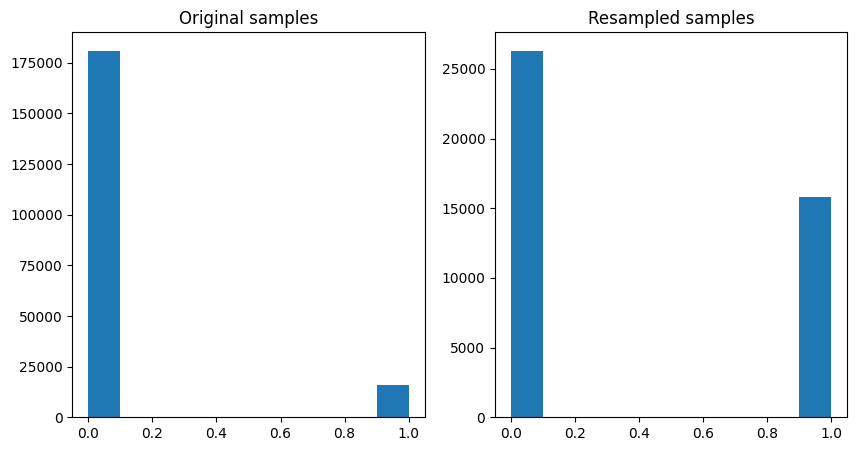

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

X_majority = X_train[y_train == 0]
X_minority = X_train[y_train == 1]

# Randomly subsample a percentage of the samples of the majority class to have a given quantity
X_majority_downsampled = resample(X_majority, 
                                  replace=False, 
                                  n_samples=int(X_minority.shape[0]*(1/0.6)), 
                                  random_state=42)

# Join the samples of the minority class with the subsampled samples of the majority class.
_X_resampled = np.concatenate((X_majority_downsampled, X_minority), axis=0)
_y_resampled = np.concatenate((np.zeros(X_majority_downsampled.shape[0]), np.ones(X_minority.shape[0])), axis=0)

X_resampled = pd.DataFrame(_X_resampled, columns= X_train.columns)
y_resampled = pd.DataFrame(_y_resampled)

# For maintain the datatypes:
cols_float = list(set(X_train.select_dtypes(include=['float']).columns.tolist()) & set(X_resampled.columns))
cols_int = list(set(X_train.select_dtypes(include=['int']).columns.tolist()) & set(X_resampled.columns))
X_resampled[list(cols_float)] = X_resampled[list(cols_float)].astype(float)
X_resampled[list(cols_int)] = X_resampled[list(cols_int)].astype(int)

print(f"X_resampled: {X_resampled.shape}")
print(f"y_resampled: {y_resampled.shape}")
print(f"X_train: {X_train.shape}")
print(f"y_train: {y_train.shape}")

print(f"CLASSES in train: {y_train.value_counts()}")
print("------------------------")
print(f"CLASSES in resampled: {y_resampled.value_counts()}")

bins = np.linspace(-5, 5, 50)
density = True
alpha = 0.5

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].hist(y_train)
axs[0].set_title('Original samples')

axs[1].hist((y_resampled))
axs[1].set_title('Resampled samples')

plt.show()

In [6]:
# All data preprocesing will be there into a class for being used into pipeline -- CleanerDataCustom -- .
# Steps for data cleaning (FIT will be made into TRAIN data only):
# 1. Find and delete features with a value of X% of null values ( could be > 60%) 
# 2. Find and delete features that have a high percentage of zeros, this indicates that it is constant ( could be > 60%).
# 3. "SK_ID_CURR" can be deleted , since it is the primary key of the table and therefore does not contribute anything to the model.
# 4. An onehotencoder is made only for the object variables

#Complexity has been greatly reduced by eliminating variables that may not contribute anything to the development of the model. 
#With the help of the business expert more columns could be eliminated, or derived fields could be made. 
#Similarly, models can be used to eliminate outliers, however, since the minority class has very few records, it is not necessary to do this procedure.

from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin

class CleanerDataCustom (BaseEstimator, TransformerMixin):
    # Constructor
    def __init__(self):
        super().__init__()
        
    # Function that makes fit
    def fit (self, X, y=None):
        columns_to_delete_nulls = self.get_cols_to_delete(X,60)
        columns_to_delete_zeros = self.get_cols_to_delete_zeros(X,60)
        self.columns_to_delete = list(set(columns_to_delete_nulls) | set(columns_to_delete_zeros) | {"SK_ID_CURR"})
        return self
    
    #Function that makes transform.
    def transform (self, X):
        X_del = X.drop(columns = self.columns_to_delete)
        return X_del

    # Function that returns a df with Variable and its null percentaje value
    def get_df_null_values(self, df):
        _nulls = df.isnull().mean()*100
        _nulls = _nulls.sort_values( ascending = False)
        result_df = pd.DataFrame({'col':_nulls.index, 'perc_nulls':_nulls.values})
        return result_df

    # Function that returns a list of features to be deleted using an threshold
    def get_cols_to_delete(self, df,threshold = 60):
        _df = self.get_df_null_values(df)
        result = _df.loc[_df["perc_nulls"]>threshold, "col"].tolist()
        return result
    
    # Function that calculates variance in each column
    def get_variance_columns (self, df):
        variances = df.var()
        var_dict = {col: variances[col] for col in df.columns}
        return var_dict
    
    # Function that calculate zero's percentage in each column
    def get_zero_percentage(self, df):
        zeros_per_col = df.eq(0).sum() / df.count() * 100
        zeros_per_col = zeros_per_col.sort_values( ascending = False)
        return pd.DataFrame({'col':zeros_per_col.index, 'perc_zeros': zeros_per_col.values})
    
    # Function that returns a list of features to be deleted using an threshold
    def get_cols_to_delete_zeros(self, df,threshold = 60):
        _df = self.get_zero_percentage(df)
        result = _df.loc[_df["perc_zeros"]>threshold, "col"].tolist()
        return result


In [11]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MaxAbsScaler
from sklearn.compose import make_column_selector
from sklearn.compose import make_column_transformer

categorical_selector = make_column_selector(dtype_include=object)

# Creamos el transformador de columnas
column_transformer = make_column_transformer(
    (OneHotEncoder(handle_unknown="ignore"), categorical_selector)
)


pipeline_steps = [
    ('custom_pre', CleanerDataCustom()),
    ("preprocessor", column_transformer),
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', MaxAbsScaler())
]

# Create pipeline
my_pipeline = Pipeline(steps=pipeline_steps)

# It is possible to use the desired ML algorthim into pipeline, for instance for random forest with the best hyperparameters obtained in RandomSearch
pipeline_randomForest_resample = Pipeline([
    ('preprocessing', my_pipeline),
    ('rf', RandomForestClassifier(max_depth=11, max_features=None, n_estimators=88,
                       n_jobs=-1))
])

In [12]:
# Finally, the selected model is trained and tested.

# Fit the model
pipeline_randomForest_resample.fit(X_resampled, y_resampled)

#For getting metrics (ROC AUC)
pipe_rf_pred_resample_train = pipeline_randomForest_resample.predict_proba(X_resampled)[:,1]
pipe_rf_pred_resample_val = pipeline_randomForest_resample.predict_proba(X_val)[:,1]

roc_auc_pipe_rf_resample_train = roc_auc_score(y_true=y_resampled, y_score=pipe_rf_pred_resample_train)
print(f"Train ROC AUC Score: {roc_auc_pipe_rf_resample_train:.4f}")

roc_auc_pipe_rf_resample_val = roc_auc_score(y_true=y_val, y_score=pipe_rf_pred_resample_val)
print(f"Val ROC AUC Score: {roc_auc_pipe_rf_resample_val:.4f}")

c:\Users\Alejo\Documents\Projects\ANY\Sprint2\Sprint2Env\Lib\site-packages\sklearn\pipeline.py:405: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


Train ROC AUC Score: 0.7378
Val ROC AUC Score: 0.6233


After performing an alternative, it is seen that the metric gave similar to those already obtained. Having the previous pipeline which deletes variables of little use, deletes variables with many nulls and zeros, then does a OneHotEncoder for categorical variables, does imputation by mean and finally a scaling or normalization.
If you want to use any other sorting algorithm just create a new pipeline using "my_pipeline" as preprocessing, followed by the desired algorithm.